# Stock Market Prediction using Decision Tree

In this notebook I take a look at stock market prediction using decision tree and linear regression.

# Importing Libraries

In [1]:
# import các thư viện cần thiết
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.model_selection import train_test_split
import statistics
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['font.size'] = 23


In [2]:
# Importing all necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data

In [3]:
# Using data from Apple's stock.
df = pd.read_csv('AAPL_data.csv') 

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1259 non-null   object 
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 69.0+ KB


In [6]:
df.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [7]:
df.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,109.055429,109.951118,108.141589,109.066698,5.404790e+07
std,30.549220,30.686186,30.376224,30.556812,3.346835e+07
min,55.424200,57.085700,55.014200,55.789900,1.147592e+07
25%,84.647800,85.334950,84.250650,84.830650,2.969438e+07
50%,108.970000,110.030000,108.050000,109.010000,4.566893e+07
75%,127.335000,128.100000,126.290000,127.120000,6.870872e+07
max,179.370000,180.100000,178.250000,179.260000,2.668336e+08


In [8]:
df.shape

(1259, 7)

# EDA

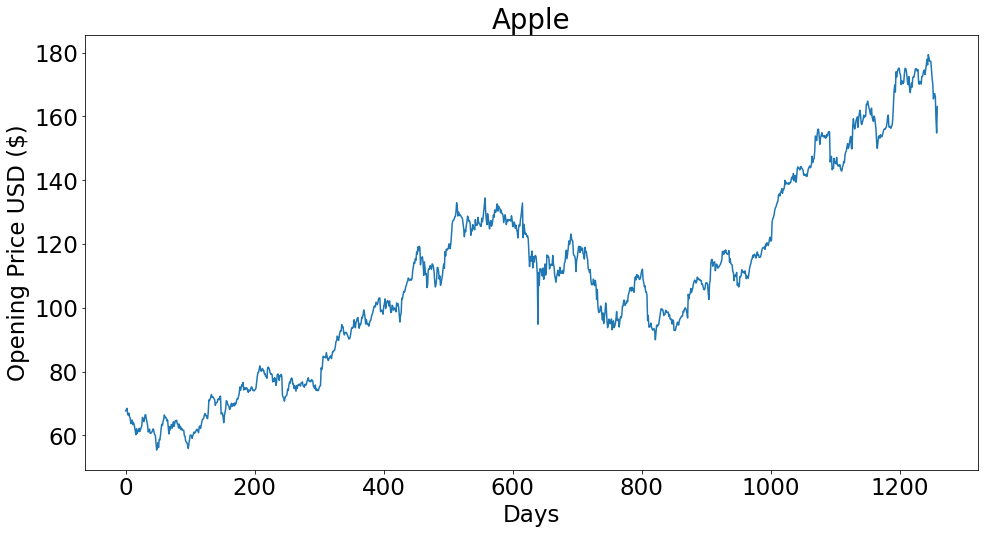

In [9]:
# Visualizing the opening prices of the data.
plt.figure(figsize=(16,8))
plt.title('Apple')
plt.xlabel('Days')
plt.ylabel('Opening Price USD ($)')
plt.plot(df['open'])
plt.show()

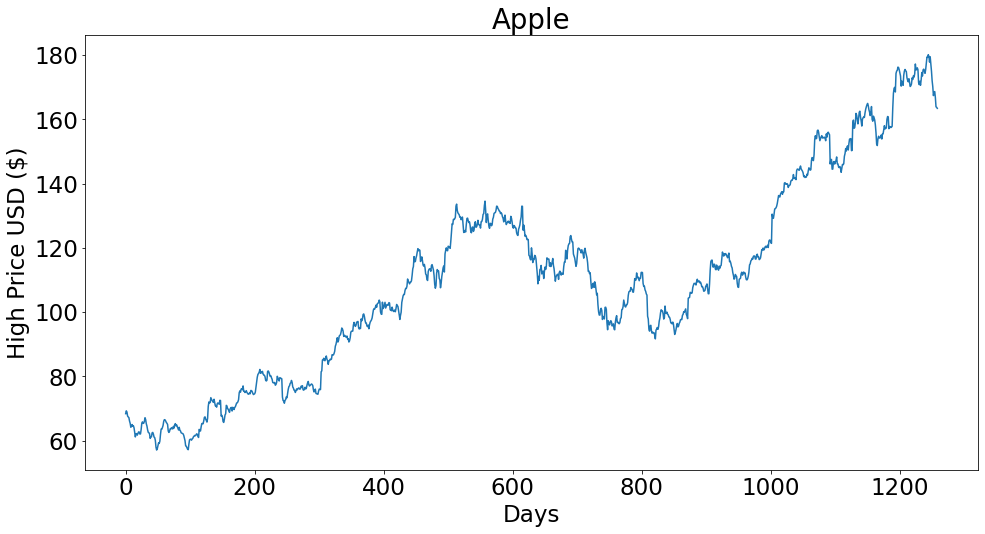

In [10]:
# Visualizing the high prices of the data.
plt.figure(figsize=(16,8))
plt.title('Apple')
plt.xlabel('Days')
plt.ylabel('High Price USD ($)')
plt.plot(df['high'])
plt.show()

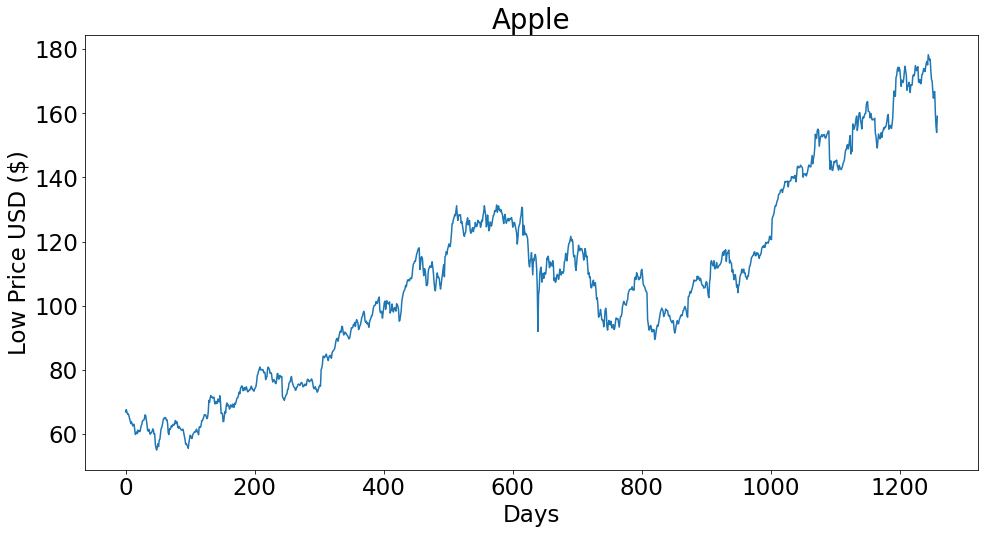

In [11]:
# Visualizing the low prices of the data.
plt.figure(figsize=(16,8))
plt.title('Apple')
plt.xlabel('Days')
plt.ylabel('Low Price USD ($)')
plt.plot(df['low'])
plt.show()

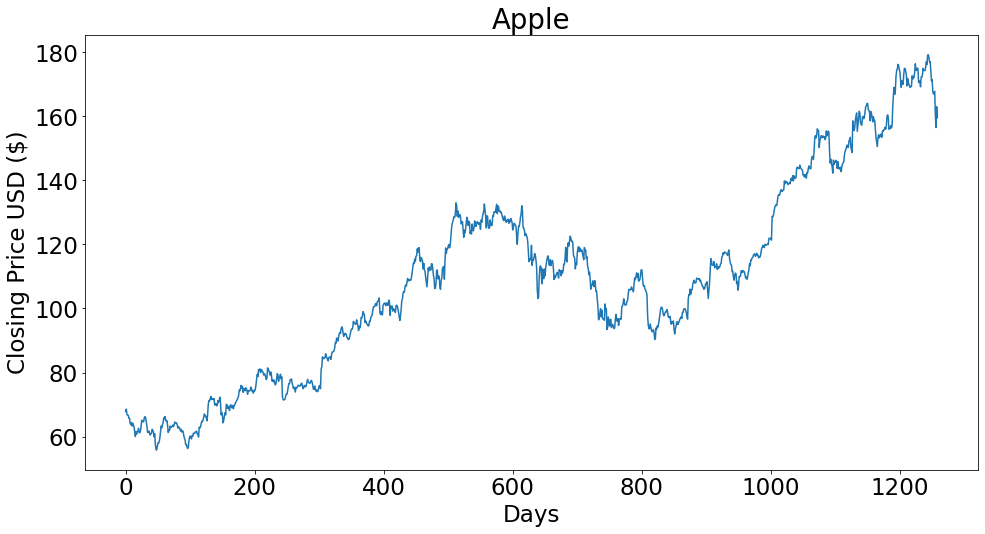

In [12]:
# Visualizing the closing prices of the data.
plt.figure(figsize=(16,8))
plt.title('Apple')
plt.xlabel('Days')
plt.ylabel('Closing Price USD ($)')
plt.plot(df['close'])
plt.show()

In [13]:
# Prediction 100 days into the future.
future_days = 100
df['Prediction'] = df['close'].shift(-future_days)

In [55]:
cor = df.corr()
feature = cor.index[abs(cor['Prediction'])>0.6].tolist()
df_FE = df[feature]
df_FE.head()

,open,high,low,close,volume,Prediction
0,67.7142,68.4014,66.8928,67.8542,158168416,60.1142
1,68.0714,69.2771,67.6071,68.5614,129029425,59.6314
2,68.5014,68.9114,66.8205,66.8428,151829363,59.2928
3,66.7442,67.6628,66.1742,66.7156,118721995,60.3357
4,66.3599,67.3771,66.2885,66.6556,88809154,60.1042


In [56]:
cor['Prediction']

open          0.875419
high          0.874672
low           0.877855
close         0.876652
volume       -0.628762
Prediction    1.000000
Name: Prediction, dtype: float64

In [15]:
df2 = df['close']

In [16]:
df2 = pd.DataFrame(df2)  

In [17]:
future_days = 100
df2['Prediction'] = df2['close'].shift(-future_days)

In [19]:
X = np.array(df2.drop(['Prediction'], 1))[:-future_days]
print(X)

[[ 67.8542]
 [ 68.5614]
 [ 66.8428]
 ...
 [160.86  ]
 [159.65  ]
 [158.28  ]]


In [20]:
y = np.array(df2['Prediction'])[:-future_days]
print(y)

[ 60.1142  59.6314  59.2928 ... 156.49   163.03   159.54  ]


# ID3

In [21]:
class ID3():
    def __init__(self):
        self.tree = None
    
    # tính entropy theo class
    def ent(self, df) -> float:
        return sum([-i*log(i) for i in df[df.columns[-1]].value_counts(normalize=True).values if i!=0])
    
    # tính entropy theo thuộc tính (attribute) + class
    def  ent_atb(self, df, atb: str) -> float:
        return abs(sum([self.ent(df[[atb, df.columns[-1]]][df[atb]==i]) * len(df[atb][df[atb]==i])/len(df) for i in df[atb].unique()]))

    # tính thông tin gain
    # đầu ra là tên thuộc tính có giá trị gain lớn nhất
    def gain(self, df) -> str:
        return df.columns[:-1][np.argmax([self.ent(df) - self.ent_atb(df, i) for i in df.columns[:-1]])]


    # lọc lấy bảng con chứa 1 loại thông tin trong 1 trường dữ liệu
    def sub_df(self, df, node, value):
        return df[df[node] == value].reset_index(drop=True)

    # xây dựng cây
    def buildTree(self, df, tree = None):
        node = self.gain(df)
        attValue = np.unique(df[node])
   
        if tree is None:                    
            tree = {}
            tree[node] = {}

        for value in attValue:
            subtable = self.sub_df(df, node, value)
            labels, counts = np.unique(subtable[df.columns[-1]],return_counts=True) 
            if len(counts) == 1:
                tree[node][value] = labels[0]                                                    
            else:        
                tree[node][value] = self.buildTree(subtable)
        return tree
        
    # fit mô hình
    def fit(self, df):
        self.tree = self.buildTree(df.astype('object'))
class ID3():
    def __init__(self):
        self.tree = None
    
    # tính entropy theo class
    def ent(self, df) -> float:
        return sum([-i*log(i) for i in df[df.columns[-1]].value_counts(normalize=True).values if i!=0])
    
    # tính entropy theo thuộc tính (attribute) + class
    def  ent_atb(self, df, atb: str) -> float:
        return abs(sum([self.ent(df[[atb, df.columns[-1]]][df[atb]==i]) * len(df[atb][df[atb]==i])/len(df) for i in df[atb].unique()]))

    # tính thông tin gain
    # đầu ra là tên thuộc tính có giá trị gain lớn nhất
    def gain(self, df) -> str:
        return df.columns[:-1][np.argmax([self.ent(df) - self.ent_atb(df, i) for i in df.columns[:-1]])]


    # lọc lấy bảng con chứa 1 loại thông tin trong 1 trường dữ liệu
    def sub_df(self, df, node, value):
        return df[df[node] == value].reset_index(drop=True)

    # xây dựng cây
    def buildTree(self, df, tree = None):
        node = self.gain(df)
        attValue = np.unique(df[node])
   
        if tree is None:                    
            tree = {}
            tree[node] = {}

        for value in attValue:
            subtable = self.sub_df(df, node, value)
            labels, counts = np.unique(subtable[df.columns[-1]],return_counts=True) 
            if len(counts) == 1:
                tree[node][value] = labels[0]                                                    
            else:        
                tree[node][value] = self.buildTree(subtable)
        return tree
        
    # fit mô hình
    def fit(self, df):
        self.tree = self.buildTree(df.astype('object'))

    # dự đoán
    def predict(self, df):
        return np.array([int(self.pred(self.tree, i)) for _, i in df.iterrows()])

    def pred(self, tree, sample) -> str:
        if not isinstance(tree, dict):
            return tree
        else:
            root_node = next(iter(tree))
            feature_value = sample[root_node]
            if feature_value in tree[root_node]:
                return self.pred(tree[root_node][feature_value], sample)
            else:
                feature_value = list(tree[root_node].keys())[0]
                return self.pred(tree[root_node][feature_value], sample)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2,random_state=42)

In [23]:
# chạy mô hình
model = ID3()
model.fit(X_train)
pprint(model.tree)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [62]:
list(model.tree.keys())[0]

'volume'

In [63]:
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

y_pred = model.predict(X_test)

In [67]:
y_pred

array([142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142,
       142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 14

In [64]:
# đánh giá mô hình với tỷ lệ dự đoán đúng
def accuracy_score(y_test, y_pred):
    return np.sum(np.equal(y_test, y_pred))/len(y_test)

accuracy_score(y_test, y_pred)

0.0

# Linear and Decision Tree Regression

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [26]:
#Implementing Linear and Decision Tree Regression Algorithms.
tree = DecisionTreeRegressor().fit(x_train, y_train)
lr = LinearRegression().fit(x_train, y_train)

In [28]:
x_future = df2.drop(['Prediction'], 1)[:-future_days]
x_future = x_future.tail(future_days)
x_future = np.array(x_future)
x_future

array([[144.53],
       [143.68],
       [143.79],
       [143.65],
       [146.58],
       [147.51],
       [147.06],
       [146.53],
       [148.96],
       [153.01],
       [153.99],
       [153.26],
       [153.95],
       [156.1 ],
       [155.7 ],
       [155.47],
       [150.25],
       [152.54],
       [153.06],
       [153.99],
       [153.8 ],
       [153.34],
       [153.87],
       [153.61],
       [153.67],
       [152.76],
       [153.18],
       [155.45],
       [153.93],
       [154.45],
       [155.37],
       [154.99],
       [148.98],
       [145.42],
       [146.59],
       [145.16],
       [144.29],
       [142.27],
       [146.34],
       [145.01],
       [145.87],
       [145.63],
       [146.28],
       [145.82],
       [143.73],
       [145.83],
       [143.68],
       [144.02],
       [143.5 ],
       [144.09],
       [142.73],
       [144.18],
       [145.06],
       [145.53],
       [145.74],
       [147.77],
       [149.04],
       [149.56],
       [150.08

In [29]:
tree_prediction = tree.predict(x_future)
print(tree_prediction)

[159.88  164.325 158.73  156.07  153.39  151.89  150.55  153.14  154.23
 153.28  154.48  153.81  154.48  170.6   155.39  157.1   171.7   155.9
 156.55  154.48  156.99  153.81  160.47  159.76  155.98  172.22  156.17
 157.1   156.41  157.41  163.05  166.72  169.04  166.89  168.11  169.48
 174.25  167.23  176.24  175.88  174.67  173.97  171.34  169.08  171.1
 169.08  164.325 167.305 158.28  174.97  174.09  173.07  169.48  171.85
 171.05  169.8   169.64  169.01  169.32  169.37  172.67  171.7   155.9
 172.22  173.97  176.42  174.54  174.35  179.26  177.09  170.57  170.6
 179.26  169.23  172.26  172.23  173.03  175.    160.5   156.49  174.29
 175.28  177.09  176.19  179.1   179.26  175.    177.    177.04  174.22
 171.11  171.51  167.96  167.96  167.43  179.26  160.5   156.49  163.03
 174.29 ]


In [30]:
lr_prediction = lr.predict(x_future)
print(lr_prediction)

[151.78504482 150.97684002 151.08143123 150.94831514 153.73424465
 154.61851579 154.19064265 153.68670319 155.9972181  159.84807629
 160.77988889 160.08578359 160.74185573 162.78613847 162.4058068
 162.18711608 157.22378775 159.40118658 159.89561775 160.77988889
 160.59923135 160.16184992 160.66578939 160.4185738  160.47562355
 159.610369   160.00971725 162.1680995  160.72283914 161.21727032
 162.09203316 161.73071808 156.01623469 152.63128279 153.74375294
 152.38406721 151.55684582 149.63617087 153.50604564 152.24144283
 153.05915593 152.83095692 153.44899589 153.01161447 151.02438148
 153.02112276 150.97684002 151.30012194 150.80569076 151.36667998
 150.07355229 151.45225461 152.28898429 152.735874   152.93554813
 154.86573137 156.07328444 156.56771561 157.06214679 157.95592622
 157.30936237 157.24280433 158.97331344 159.59135241 160.27594943
 157.5185448  156.51066586 155.77852739 165.15370313 163.77500082
 162.282199   163.06187893 165.36288555 166.57043862 167.50225122
 162.044491

In [31]:
predictions = tree_prediction 
valid = df2[X.shape[0]:]
valid['Predictions'] = predictions

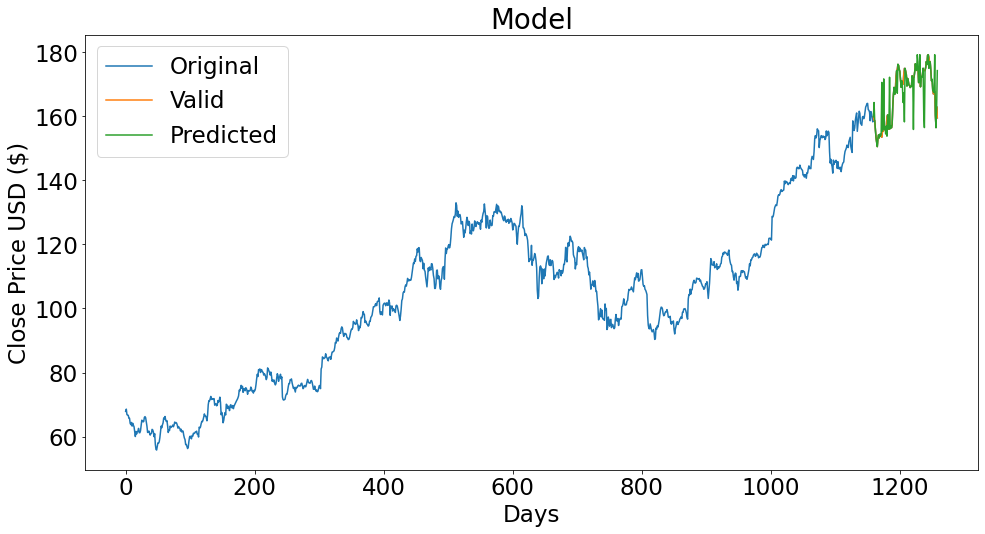

In [32]:
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(df2['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(["Original", "Valid", 'Predicted'])
plt.show()